# Introduction/Business Problem

A European-based rock climbing gear manufacturer is planning the launch of a brand new climbing shoe that they consider 'revolutionary'.  Backed by the slogan of "Send Anything; Send Always", the company is claiming that the new shoes will enable climbers of all skill levels to climb (aka "Send") harder routes than they have ever climbed in the past due to a new rubber compound they have formulated. 

The company's marketing campaign will be critical to driving interest in the new shoes, and their digital marketing team has come up with their vision for the content they will produce for online ads.  The team has decided that they want to photograph their best sponsored athlete on location, in the United States, climbing some of the most technically difficult rock climbs the US has to offer - showcasing the new shoes' high performance capabilities.

The team they will assemble has been selected; however, due to upstream delays in production, their window for capturing their marketing content has been compressed.  The team will need to schedule their travel fairly quickly, and they need to determine where they will be travelling to within the United States.  This will be the first time to the United States for the entire team, so they need help determining the best location.  There are requirements for where they will travel:

- There needs to be a high volume of technically difficult climbing routes in the area; they need to be hard enough to highlight the shoes' performance
- Because this is the team's first time to the US, they want to be able to enjoy themselves after working all day in the mountains.  The team has a 'work hard; play hard' mentality, so they are looking to stay in a town that offers a lot of options for pubs and breweries

The team has only heard of a few potential locations that are of interest (e.g. Yosemite National Park; Red Rocks near Las Vegas; "The Gunks" in New York); however, they don't have the time themselves to do extensive research into multiple locations.  They have asked a Data Scientist to quickly access different data sources and to perform some fundamental analysis to identify their final destination.  Ultimately, the team needs a recommendation for where they should narrow their search when booking their Air BnB.

# Data Sources

#### Data Source #1: Mountain Project:

Mountain Project is a crowd-sourced platform for Rock Climbers to catalogue and inventory information about specific rock climbing routes and areas.  It is largely considered the definitive source for rock climbing route information.  While separate guide books are often created for individual climbing areas to provide even greater details about the climbs, Mountain Project (MP) is the preeminent, centralized platform for climbing information.  I will leverage Mountain Project's API to pull data from their databases.

A basic primer on rock climbing route information:

    - All routes are named by the individual who is the first ascensionist
    - All routes are given a grade/rating for their difficulty; this is a consensus-based system where the grade is determined based on the opinions of all individuals who climb the route
    - Mountain Project allows its user community to rate the climb for enjoyment factor, which is captured in a 0-4 star format
    - Mountain Project retains latitude and longitude data for each climb
    - Mountain Project also allows its user community to leave commentary, upload pictures, start topic threads, etc.  Note:  This data will likely not be leveraged during this assignment
    
Additional information on the system for rock climbing grading difficulty:

    - All routes are given a grade/rating for their difficulty; this is a consensus-based system where the grade is determined based on the opinions of all individuals who climb the route
    - The grading system leveraged is known as the Yosemite Decimal System, which is a number-based scale to signal difficulty
    - The numbers start at 5.0 (which is the easiest rock climbing grade) and incrementally increase by 0.1 as difficulty increases.  So, the next level after 5.0 is 5.1, then 5.2, 5.3 ... etc
    - The pattern for the grading convention shifts slightly after 5.9; grades then add 0.01 and one of 4 letters (a, b, c, d) to indicate difficulty.  So, the next level after 5.9 is 5.10a, then 5.10b, 5.10c, 5.10d, 5.11a, 5.11b ... etc.  
    - The current max difficulty grade is 5.15d
    - Pro level rock climbing is generally considered to start at 5.14a

Because a requirement from the marketing team is to find an area with a high density of difficult climbing for their sponsored athlete to climb, this analysis will define a "difficult climb" as anything graded 5.14a or higher.  This parameter will be passed through the API call to MP during the assignment.

Mountain Project Website:
https://www.mountainproject.com/

#### Data Source #2: FourSquare:


###### Note:  Because this capstone, as well as required assignments in the course, mandates the use of FourSquare and its API, I am going to assume this is familiar to the reader/audience.  I will, therefore, make the description of this data source more concise than the Mountain Project description.

FourSquare is a crowd-sourced, location-based service that offers data about venues around the world.  According to FourSquare's website: "Our global point-of-interest (POI) data, rich with context, is based on over 46K trusted sources and validated by millions of consumers. Create location-based experiences with a map unlike any other."  Venue data includes, but is not limited to: Name, category, rating, latitude, longitude, etc.  

This analysis will leverage the FourSquare API to analyze information pertaining to the Marketing team's second requirement: finding a town that offers a high concentration of, and ample options for, bars, breweries, gastro pubs, etc.


FourSquare Website:  https://foursquare.com/


#### Analysis Section

In [3]:
#Importing packages and libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


!conda config --set allow_conda_downgrades true
!conda install conda=4.6.14
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - conda=4.6.14


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.6.14               |           py37_0         1.9 MB
    pycosat-0.6.3              |   py37h27cfd23_0          81 KB
    ruamel_yaml-0.15.87        |   py37h7b6447c_1         245 KB
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  conda              pkgs/main/linux-64::conda-4.6.14-py37_0
  pycosat            pkgs/main/linux-64::pycosat-0.6.3-py37h27cfd23_0
  ruamel_yaml        pkgs/main/linux-64::ruamel_yaml-0.15.87-py37h7b6447c_1



ruamel_yaml-0.15.87  | 245 KB    | ###

###### For this analysis, I will narrow it down to 5-6 key locations.  The marketing team mentioned 3 (i.e. Yosemite, Red Rocks and The Gunks); I have chosen 3 more popular climbing locations (i.e. Boulder, CO; Bend, OR; and Moab, UT).

In [6]:
#using the geocode caller to establish latitudes and longitudes for the cities in the analysis.  Notice it is in the format of city, country, so US has to follow.
#Will explore the following Rock Climbing 'hubs':  Boulder, CO; Las Vegas (Red Rocks), NV; New Paltz (The Gunks), NY; Bend, OR; Moab, UT; and, Merced (Yosemite), CA
addressBO = 'Boulder, US'
geolocatorBO = Nominatim(user_agent="boulder_explorer")
locationBO = geolocatorBO.geocode(addressBO)
latitudeBO = locationBO.latitude
longitudeBO = locationBO.longitude

addressLV = 'Las Vegas, US'
geolocatorLV = Nominatim(user_agent="las_vegas_explorer")
locationLV = geolocatorLV.geocode(addressLV)
latitudeLV = locationLV.latitude
longitudeLV = locationLV.longitude

addressNY = 'New Paltz, US'
geolocatorNY = Nominatim(user_agent="new_paltz_explorer")
locationNY = geolocatorNY.geocode(addressNY)
latitudeNY = locationNY.latitude
longitudeNY = locationNY.longitude

addressOR = 'Bend, US'
geolocatorOR = Nominatim(user_agent="bend_explorer")
locationOR = geolocatorOR.geocode(addressOR)
latitudeOR = locationOR.latitude
longitudeOR = locationOR.longitude

addressUT = 'Moab, US'
geolocatorUT = Nominatim(user_agent="moab_explorer")
locationUT = geolocatorUT.geocode(addressUT)
latitudeUT = locationUT.latitude
longitudeUT = locationUT.longitude

addressCA = 'Merced, US'
geolocatorCA = Nominatim(user_agent="merced_explorer")
locationCA = geolocatorCA.geocode(addressCA)
latitudeCA = locationCA.latitude
longitudeCA = locationCA.longitude


print('The geograpical coordinate of Boulder are {}, {}.'.format(latitudeBO, longitudeBO))
print('The geograpical coordinate of Las Vegas are {}, {}.'.format(latitudeLV, longitudeLV))
print('The geograpical coordinate of New Paltz are {}, {}.'.format(latitudeNY, longitudeNY))
print('The geograpical coordinate of Bend are {}, {}.'.format(latitudeOR, longitudeOR))
print('The geograpical coordinate of Moab are {}, {}.'.format(latitudeUT, longitudeUT))
print('The geograpical coordinate of Merced are {}, {}.'.format(latitudeCA, longitudeCA))

The geograpical coordinate of Boulder are 40.0149856, -105.2705456.
The geograpical coordinate of Las Vegas are 36.1672559, -115.1485163.
The geograpical coordinate of New Paltz are 41.7464972, -74.0844894.
The geograpical coordinate of Bend are 44.0581728, -121.3153096.
The geograpical coordinate of Moab are 38.5738096, -109.5462146.
The geograpical coordinate of Merced are 37.1641544, -120.7678602.


In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
#Sending Get request for Boulder
resultsBO = requests.get(urlBO).json()
resultsBO

{'routes': [{'id': 109676924,
   'name': 'Portrait in Flesh',
   'type': 'Sport',
   'rating': '5.14a',
   'stars': 5,
   'starVotes': 12,
   'pitches': 1,
   'location': ['Colorado', 'Golden', 'Clear Creek Canyon', 'Primo Wall'],
   'url': 'https://www.mountainproject.com/route/109676924/portrait-in-flesh',
   'imgSqSmall': 'https://cdn2.apstatic.com/photos/climb/114370589_sqsmall_1526353256.jpg',
   'imgSmall': 'https://cdn2.apstatic.com/photos/climb/114370589_small_1526353256.jpg',
   'imgSmallMed': 'https://cdn2.apstatic.com/photos/climb/114370589_smallMed_1526353256.jpg',
   'imgMedium': 'https://cdn2.apstatic.com/photos/climb/114370589_medium_1526353256.jpg',
   'longitude': -105.4153,
   'latitude': 39.7393},
  {'id': 107348944,
   'name': "Grand Ol' Opry",
   'type': 'Sport',
   'rating': '5.14b',
   'stars': 5,
   'starVotes': 4,
   'pitches': 1,
   'location': ['Colorado',
    'Estes Park Valley',
    'Big Thompson Canyon',
    'The Monastery',
    'The Vestibule'],
   'url':

In [22]:
#Sending Get request for Las Vegas
resultsLV = requests.get(urlLV).json()
resultsLV

{'routes': [{'id': 112393443,
   'name': 'Herbivour Dyno-soar',
   'type': 'Sport',
   'rating': '5.14a',
   'stars': 4.8,
   'starVotes': 11,
   'pitches': 1,
   'location': ['Nevada',
    'Southern Nevada',
    'Red Rock',
    '05-Sandstone Quarry',
    'The Secret 13 Wall'],
   'url': 'https://www.mountainproject.com/route/112393443/herbivour-dyno-soar',
   'imgSqSmall': 'https://cdn2.apstatic.com/photos/climb/112393540_sqsmall_1494302269.jpg',
   'imgSmall': 'https://cdn2.apstatic.com/photos/climb/112393540_small_1494302269.jpg',
   'imgSmallMed': 'https://cdn2.apstatic.com/photos/climb/112393540_smallMed_1494302269.jpg',
   'imgMedium': 'https://cdn2.apstatic.com/photos/climb/112393540_medium_1494302269.jpg',
   'longitude': -115.4504,
   'latitude': 36.1707},
  {'id': 113056542,
   'name': 'The Other',
   'type': 'Sport',
   'rating': '5.14a',
   'stars': 5,
   'starVotes': 3,
   'pitches': 1,
   'location': ['Nevada',
    'Southern Nevada',
    'Mount Charleston',
    "Robber's 

In [23]:
#Sending Get request for New Paltz
resultsNY = requests.get(urlNY).json()
resultsNY

{'routes': [], 'success': 1}

In [24]:
#Sending Get request for Bend
resultsOR = requests.get(urlOR).json()
resultsOR

{'routes': [{'id': 109007955,
   'name': 'Just Do It',
   'type': 'Sport',
   'rating': '5.14c',
   'stars': 5,
   'starVotes': 2,
   'pitches': 1,
   'location': ['Oregon', 'Central Oregon', 'Smith Rock', 'Monkey Face'],
   'url': 'https://www.mountainproject.com/route/109007955/just-do-it',
   'imgSqSmall': 'https://cdn2.apstatic.com/photos/climb/109008245_sqsmall_1494302719.jpg',
   'imgSmall': 'https://cdn2.apstatic.com/photos/climb/109008245_small_1494302719.jpg',
   'imgSmallMed': 'https://cdn2.apstatic.com/photos/climb/109008245_smallMed_1494302719.jpg',
   'imgMedium': 'https://cdn2.apstatic.com/photos/climb/109008245_medium_1494302719.jpg',
   'longitude': -121.1436,
   'latitude': 44.3705},
  {'id': 105891749,
   'name': 'Scarface',
   'type': 'Sport',
   'rating': '5.14a',
   'stars': 5,
   'starVotes': 5,
   'pitches': 1,
   'location': ['Oregon',
    'Central Oregon',
    'Smith Rock',
    'Christian Brothers',
    'Christian Brothers - East Side'],
   'url': 'https://www.

In [25]:
#Sending Get request for Moab
resultsUT = requests.get(urlUT).json()
resultsUT

{'routes': [{'id': 108138178,
   'name': 'The Bleeding',
   'type': 'Sport',
   'rating': '5.14b',
   'stars': 5,
   'starVotes': 2,
   'pitches': '',
   'location': ['Utah',
    'Southeast Utah',
    'La Sal Mountains',
    'Mill Creek',
    'The Wicked Crag'],
   'url': 'https://www.mountainproject.com/route/108138178/the-bleeding',
   'imgSqSmall': 'https://cdn2.apstatic.com/photos/climb/119378033_sqsmall_1597350062.jpg',
   'imgSmall': 'https://cdn2.apstatic.com/photos/climb/119378033_small_1597350062.jpg',
   'imgSmallMed': 'https://cdn2.apstatic.com/photos/climb/119378033_smallMed_1597350062.jpg',
   'imgMedium': 'https://cdn2.apstatic.com/photos/climb/119378033_medium_1597350062.jpg',
   'longitude': -109.3102,
   'latitude': 38.4969},
  {'id': 111736505,
   'name': 'Stranger Than Fiction',
   'type': 'Trad',
   'rating': '5.14-',
   'stars': 5,
   'starVotes': 1,
   'pitches': '',
   'location': ['Utah', 'Southeast Utah', 'Bartlett Wash'],
   'url': 'https://www.mountainproject

In [26]:
#Sending Get request for Merced
resultsCA = requests.get(urlCA).json()
resultsCA

{'routes': [], 'success': 1}

In [10]:
#adjusting max radius too 100 miles
radius2 = 100
urlCA2 = 'https://www.mountainproject.com/data/get-routes-for-lat-lon?lat={}&lon={}&maxDistance={}&minDiff=5.14a&maxDiff=5.15d&key={}'.format(
    latitudeCA, 
    longitudeCA,
    radius2,
    MPKey)

In [11]:
#Sending Get request for Merced at expanded radius
resultsCA2 = requests.get(urlCA2).json()
resultsCA2

{'routes': [{'id': 109951912,
   'name': 'Dawn Wall Free',
   'type': 'Trad, Boulder',
   'rating': '5.14c V1',
   'stars': 3.5,
   'starVotes': 36,
   'pitches': 32,
   'location': ['California',
    'Yosemite National Park',
    'Yosemite Valley',
    'Valley North Side',
    'El Capitan',
    'Southeast Face'],
   'url': 'https://www.mountainproject.com/route/109951912/dawn-wall-free',
   'imgSqSmall': 'https://cdn2.apstatic.com/photos/climb/109951921_sqsmall_1494366127.jpg',
   'imgSmall': 'https://cdn2.apstatic.com/photos/climb/109951921_small_1494366127.jpg',
   'imgSmallMed': 'https://cdn2.apstatic.com/photos/climb/109951921_smallMed_1494366127.jpg',
   'imgMedium': 'https://cdn2.apstatic.com/photos/climb/109951921_medium_1494366127.jpg',
   'longitude': -119.6344,
   'latitude': 37.7295},
  {'id': 108716114,
   'name': 'Magic Mushroom',
   'type': 'Trad, Aid',
   'rating': '5.14a A3',
   'stars': 5,
   'starVotes': 1,
   'pitches': 31,
   'location': ['California',
    'Yosemit

In [12]:
#Cleaning and structuring these into DFs
routesCA2 = resultsCA2['routes']
    
nearby_routesCA2 = json_normalize(routesCA2) # flatten JSON

# filter columns
filtered_columns = ['name', 'type', 'rating', 'stars','pitches','latitude','longitude']
nearby_routesCA2 =nearby_routesCA2.loc[:, filtered_columns]

# clean columns
nearby_routesCA2.columns = [col.split(".")[-1] for col in nearby_routesCA2.columns]

nearby_routesCA2.head()

,name,type,rating,stars,pitches,latitude,longitude
0,Dawn Wall Free,"Trad, Boulder",5.14c V1,3.5,32,37.7295,-119.6344
1,Magic Mushroom,"Trad, Aid",5.14a A3,5.0,31,37.7305,-119.6383
2,Green Mile,Sport,5.14c,4.7,,37.9070,-120.5582
3,Broken Arrow,Trad,5.14a,5.0,1,37.8156,-119.4884
4,Full House,Sport,5.14b/c,5.0,1,37.9070,-120.5582


In [14]:
print(nearby_routesCA2.shape)
nearby_routesCA2.describe()

(16, 7)


,stars,latitude,longitude
count,16.000000,16.000000,16.000000
mean,4.156250,37.688656,-120.401856
std,0.544021,0.479783,0.513618
min,3.000000,36.473100,-121.187000
25%,4.000000,37.730250,-120.558200
50%,4.000000,37.907000,-120.558200
75%,4.400000,37.907000,-120.346950
max,5.000000,37.907000,-119.488400


In [9]:
#Cleaning and structuring these into DFs
routesBO = resultsBO['routes']
    
nearby_routesBO = json_normalize(routesBO) # flatten JSON

# filter columns
filtered_columns = ['name', 'type', 'rating', 'stars','pitches','latitude','longitude']
nearby_routesBO =nearby_routesBO.loc[:, filtered_columns]

# clean columns
nearby_routesBO.columns = [col.split(".")[-1] for col in nearby_routesBO.columns]

nearby_routesBO.head()

,name,type,rating,stars,pitches,latitude,longitude
0,Portrait in Flesh,Sport,5.14a,5.0,1,39.7393,-105.4153
1,Grand Ol' Opry,Sport,5.14b,5.0,1,40.4533,-105.3691
2,"Double Stout (w/ extension, AKA Imperial Stout)",Sport,5.14a,5.0,1,39.7388,-105.3222
3,Primeval,Sport,5.14a,4.4,1,39.7393,-105.4153
4,I Am The Walrus,Sport,5.14a,4.8,1,39.9683,-105.2880


In [24]:
grade_countBO = nearby_routesBO.groupby('rating').count()
grade_countBO

,name,type,stars,pitches,latitude,longitude
rating,,,,,,
5.14,2,2,2,2,2,2
5.14-,4,4,4,4,4,4
5.14a,26,26,26,26,26,26
5.14a R,1,1,1,1,1,1
5.14a/b,3,3,3,3,3,3
5.14b,10,10,10,10,10,10
5.14c,3,3,3,3,3,3
5.14c/d,1,1,1,1,1,1


Text(0, 0.5, 'Count')

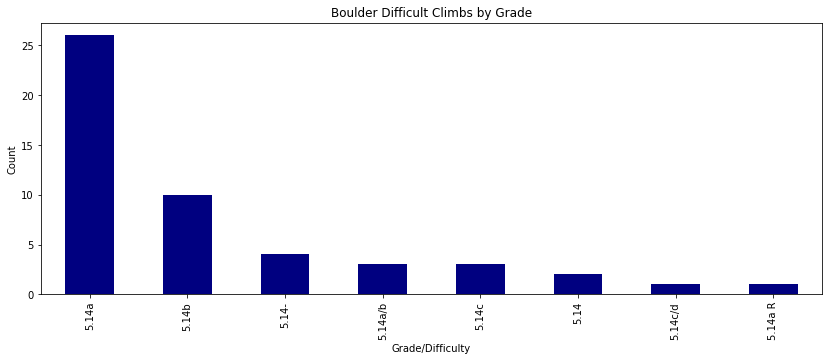

In [79]:
BORatings = nearby_routesBO['rating'].value_counts().plot(kind='bar',
                                                        figsize=(14,5),
                                                        color = ('navy'),
                                                        title="Boulder Difficult Climbs by Grade")
BORatings.set_xlabel('Grade/Difficulty')
BORatings.set_ylabel('Count')

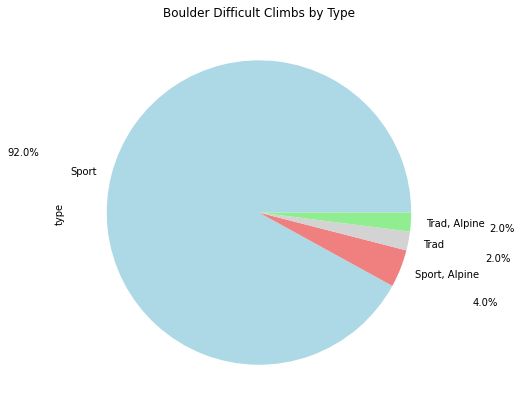

In [82]:

BOTypes = nearby_routesBO['type'].value_counts().plot(kind='pie',
                                                        figsize=(19,7),
                                                        colors = ('lightblue','lightcoral','lightgrey','lightgreen'),
                                                        autopct='%1.1f%%',
                                                        pctdistance = 1.6,
                                                        title="Boulder Difficult Climbs by Type")



Text(0, 0.5, 'Star Rating')

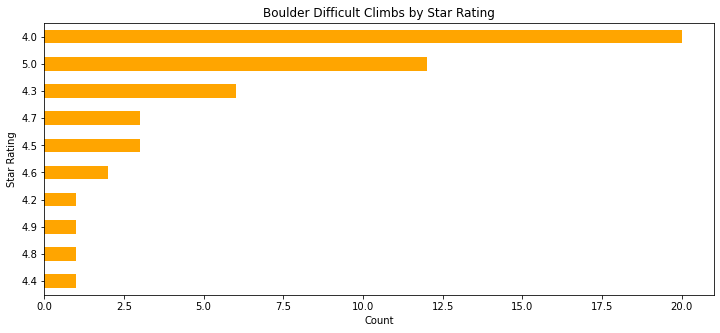

In [85]:
BOStars = nearby_routesBO['stars'].value_counts().plot(kind='barh',
                                                        figsize=(12,5),
                                                        color = ('orange'),
                                                        title="Boulder Difficult Climbs by Star Rating")
BOStars.invert_yaxis()
BOStars.set_xlabel('Count')
BOStars.set_ylabel('Star Rating')

In [28]:
#Cleaning and structuring these into DFs
routesLV = resultsLV['routes']
    
nearby_routesLV = json_normalize(routesLV) # flatten JSON

# filter columns

nearby_routesLV =nearby_routesLV.loc[:, filtered_columns]

# clean columns
nearby_routesLV.columns = [col.split(".")[-1] for col in nearby_routesLV.columns]

nearby_routesLV.head()

,name,type,rating,stars,pitches
0,Herbivour Dyno-soar,Sport,5.14a,4.8,1
1,The Other,Sport,5.14a,5.0,1
2,Jesus Called Me a Dick,Sport,5.14a,5.0,1
3,Manphibian,Sport,5.14d,5.0,
4,The Eggporkalypse,Sport,5.14d,5.0,


In [30]:
#Cleaning and structuring these into DFs
routesOR = resultsOR['routes']
    
nearby_routesOR = json_normalize(routesOR) # flatten JSON

# filter columns

nearby_routesOR =nearby_routesOR.loc[:, filtered_columns]

# clean columns
nearby_routesOR.columns = [col.split(".")[-1] for col in nearby_routesOR.columns]

nearby_routesOR.head()

,name,type,rating,stars,pitches
0,Just Do It,Sport,5.14c,5.0,1
1,Scarface,Sport,5.14a,5.0,1
2,To Bolt Or Not To Be,Sport,5.14a,4.8,1
3,Mojo,Sport,5.14b,5.0,1
4,Badman,Sport,5.14a,5.0,


In [31]:
#Cleaning and structuring these into DFs
routesUT = resultsUT['routes']
    
nearby_routesUT = json_normalize(routesUT) # flatten JSON

# filter columns

nearby_routesUT =nearby_routesUT.loc[:, filtered_columns]

# clean columns
nearby_routesUT.columns = [col.split(".")[-1] for col in nearby_routesUT.columns]

nearby_routesUT.head()

,name,type,rating,stars,pitches
0,The Bleeding,Sport,5.14b,5,
1,Stranger Than Fiction,Trad,5.14-,5,
2,Doubloon,Sport,5.14b,4,1
3,Open Project,Sport,5.14+,4,1


###### Note that neither New Paltz, NY nor Merced, CA had any routes that fit the difficulty requirements within 50 miles (which is confirmed by a successful API call with no data returned).  This is indicative of the fact some of the most well-known rock climbing destinations in the US (The Gunks in NY & Yosemite in CA) do not have grades that reach the level of difficulty the team is looking for.  DataFrames were, therefore, not created since there was no data returned. 

###### It is also my suspicion that neither of these towns will have many locations of interest that the marketing team required as well.  This will be explored later in the analysis.

In [33]:
#Getting Shape for DFs
print("The shape of the Boulder dataframe is:")
print(nearby_routesBO.shape)

The shape of the Boulder dataframe is:
(50, 5)


In [34]:
#Getting Shape
print("The shape of the Las Vegas dataframe is:")
print(nearby_routesLV.shape)

The shape of the Las Vegas dataframe is:
(39, 5)


In [35]:
#Getting Shape
print("The shape of the Bend dataframe is:")
print(nearby_routesOR.shape)

The shape of the Bend dataframe is:
(13, 5)


In [36]:
#Getting Shape
print("The shape of the dataframe is:")
print(nearby_routesUT.shape)

The shape of the dataframe is:
(4, 5)


In [37]:
#Getting summary statistics for the DFs
nearby_routesBO.describe()

,stars
count,50.000000
mean,4.418000
std,0.413887
min,4.000000
25%,4.000000
50%,4.300000
75%,4.875000
max,5.000000


In [40]:
#Getting summary statistics for the DFs
nearby_routesLV.describe()

,stars
count,39.000000
mean,4.207692
std,0.622552
min,3.000000
25%,4.000000
50%,4.000000
75%,4.900000
max,5.000000


In [39]:
#Getting summary statistics for the DFs
nearby_routesOR.describe()

,stars
count,13.000000
mean,4.238462
std,1.353722
min,0.000000
25%,4.000000
50%,4.800000
75%,5.000000
max,5.000000


In [38]:
#Getting summary statistics for the DFs
nearby_routesUT.describe()

,stars
count,4.00000
mean,4.50000
std,0.57735
min,4.00000
25%,4.00000
50%,4.50000
75%,5.00000
max,5.00000


In [41]:
print("Boulder,CO has",nearby_routesBO['name'].count(),"routes that fit the difficulty level you're looking for, and these routes have an average rating of:",nearby_routesBO['stars'].mean())
print("Las Vegas,NV has",nearby_routesLV['name'].count(),"routes that fit the difficulty level you're looking for, and these routes have an average rating of:",nearby_routesLV['stars'].mean())
print("Bend, OR has",nearby_routesOR['name'].count(),"routes that fit the difficulty level you're looking for, and these routes have an average rating of:",nearby_routesOR['stars'].mean())
print("Moab, UT has",nearby_routesUT['name'].count(),"routes that fit the difficulty level you're looking for, and these routes have an average rating of:",nearby_routesUT['stars'].mean())

Boulder,CO has 50 routes that fit the difficulty level you're looking for, and these routes have an average rating of: 4.418000000000001
Las Vegas,NV has 39 routes that fit the difficulty level you're looking for, and these routes have an average rating of: 4.207692307692307
Bend, OR has 13 routes that fit the difficulty level you're looking for, and these routes have an average rating of: 4.2384615384615385
Moab, UT has 4 routes that fit the difficulty level you're looking for, and these routes have an average rating of: 4.5


In [44]:
# The code was removed by Watson Studio for sharing.

In [223]:
#Getting the top venues near each city within 5000 meters
radius2 = 5000
#create url 
urlBO2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitudeBO, 
    longitudeBO, 
    radius2, 
    LIMIT)

urlLV2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitudeLV, 
    longitudeLV, 
    radius2, 
    LIMIT)

urlOR2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitudeOR, 
    longitudeOR, 
    radius2, 
    LIMIT)

urlUT2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitudeUT, 
    longitudeUT, 
    radius2, 
    LIMIT)

urlNY2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitudeNY, 
    longitudeNY, 
    radius2, 
    LIMIT)

urlCA2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitudeCA, 
    longitudeCA, 
    radius2, 
    LIMIT)



In [54]:
#Sending Get requests to FourSquare for each city
resultsBO2 = requests.get(urlBO2).json()
resultsBO2

{'meta': {'code': 200, 'requestId': '5fd7dc4030af53624b0a5564'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Boulder',
  'headerFullLocation': 'Boulder',
  'headerLocationGranularity': 'city',
  'totalResults': 232,
  'suggestedBounds': {'ne': {'lat': 40.05998564500005,
    'lng': -105.21189902099127},
   'sw': {'lat': 39.96998555499996, 'lng': -105.32919217900874}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d3cac5a8edf3704e894b2a5',
       'name': 'Pizzeria Locale',
       'location': {'address': '1730 Pearl St',
        'lat': 40.019208,
        'lng': -105.272611,
        'labeledLatLngs': [{'label': 'display',
          'lat': 

In [49]:
#Sending Get requests to FourSquare for each city
resultsLV2 = requests.get(urlLV2).json()
resultsLV2

{'meta': {'code': 200, 'requestId': '5fd7dbbb7d6cea4fd32b94df'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Las Vegas',
  'headerFullLocation': 'Las Vegas',
  'headerLocationGranularity': 'city',
  'totalResults': 232,
  'suggestedBounds': {'ne': {'lat': 36.212255945000045,
    'lng': -115.09287880174011},
   'sw': {'lat': 36.122255854999956, 'lng': -115.20415379825988}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b870646f964a5200dac31e3',
       'name': 'The Smith Center for the Performing Arts',
       'location': {'address': '361 Symphony Park Ave',
        'lat': 36.16915697948935,
        'lng': -115.15155568698239,
        'l

In [50]:
#Sending Get requests to FourSquare for each city
resultsOR2 = requests.get(urlOR2).json()
resultsOR2

{'meta': {'code': 200, 'requestId': '5fd7dbc8e8e116439279fb8a'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bend',
  'headerFullLocation': 'Bend',
  'headerLocationGranularity': 'city',
  'totalResults': 211,
  'suggestedBounds': {'ne': {'lat': 44.103172845000046,
    'lng': -121.252807664209},
   'sw': {'lat': 44.01317275499996, 'lng': -121.37781153579101}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5093fda9e4b079e22f238eef',
       'name': 'Crows Feet Commons',
       'location': {'address': '875 NW Brooks St',
        'lat': 44.05943899622788,
        'lng': -121.31500612783674,
        'labeledLatLngs': [{'label': 'display',
  

In [51]:
#Sending Get requests to FourSquare for each city
resultsUT2 = requests.get(urlUT2).json()
resultsUT2

{'meta': {'code': 200, 'requestId': '5fd7dbd7b3e08220d641de3b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Moab',
  'headerFullLocation': 'Moab',
  'headerLocationGranularity': 'city',
  'totalResults': 70,
  'suggestedBounds': {'ne': {'lat': 38.61880964500004,
    'lng': -109.48876294398627},
   'sw': {'lat': 38.52880955499995, 'lng': -109.60366625601372}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd4541377b29c7491659282',
       'name': 'Love Muffin Cafe',
       'location': {'address': '139 N Main St',
        'lat': 38.57548275696959,
        'lng': -109.5509819932772,
        'labeledLatLngs': [{'label': 'display',
        

In [55]:
#Sending Get requests to FourSquare for each city
resultsNY2 = requests.get(urlNY2).json()
resultsNY2

{'meta': {'code': 200, 'requestId': '5fd7dc5821d05f4d8135e941'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'New Paltz',
  'headerFullLocation': 'New Paltz',
  'headerLocationGranularity': 'city',
  'totalResults': 112,
  'suggestedBounds': {'ne': {'lat': 41.791497245000045,
    'lng': -74.02428816665808},
   'sw': {'lat': 41.701497154999956, 'lng': -74.14469063334191}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4dab84f293a04642f09812c8',
       'name': 'a tavola',
       'location': {'address': '46 Main St',
        'lat': 41.74733874796098,
        'lng': -74.0870538874267,
        'labeledLatLngs': [{'label': 'display',
         

In [56]:
#Sending Get requests to FourSquare for each city
resultsCA2 = requests.get(urlCA2).json()
resultsCA2

{'meta': {'code': 200, 'requestId': '5fd7dc66abab3133136bbcdc'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 37.209154445000046,
    'lng': -120.71149732750287},
   'sw': {'lat': 37.11915435499996, 'lng': -120.82422307249713}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4f322b3c19836c91c7bcf2ff',
       'name': 'Carniceria Cuxpala',
       'location': {'address': '13504 Palazzo Rd',
        'lat': 37.12984848022461,
        'lng': -120.74524688720703,
        'labeledLatLngs': [{

In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [105]:
#Cleaning and structuring into DFs
venuesBO = resultsBO2['response']['groups'][0]['items']
    
nearby_venuesBO = json_normalize(venuesBO) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venuesBO =nearby_venuesBO.loc[:, filtered_columns]

# filter the category for each row
nearby_venuesBO['venue.categories'] = nearby_venuesBO.apply(get_category_type, axis=1)

# clean columns
nearby_venuesBO.columns = [col.split(".")[-1] for col in nearby_venuesBO.columns]

nearby_venuesBO.head()

,name,categories,lat,lng
0,Pizzeria Locale,Pizza Place,40.019208,-105.272611
1,Boxcar Coffee Roasters,Coffee Shop,40.019796,-105.271443
2,"Snooze, an A.M. Eatery",Breakfast Spot,40.019127,-105.274285
3,Boulder Farmers' Market,Farmers Market,40.015536,-105.277652
4,Frasca Food and Wine,Italian Restaurant,40.019314,-105.272285


In [106]:
#Cleaning and structuring into DFs
venuesLV = resultsLV2['response']['groups'][0]['items']
    
nearby_venuesLV = json_normalize(venuesLV) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venuesLV =nearby_venuesLV.loc[:, filtered_columns]

# filter the category for each row
nearby_venuesLV['venue.categories'] = nearby_venuesLV.apply(get_category_type, axis=1)

# clean columns
nearby_venuesLV.columns = [col.split(".")[-1] for col in nearby_venuesLV.columns]

nearby_venuesLV.head()

,name,categories,lat,lng
0,The Smith Center for the Performing Arts,Theater,36.169157,-115.151556
1,Pop Up Pizza,Pizza Place,36.171171,-115.147438
2,Carson Kitchen,Gastropub,36.167884,-115.140664
3,VegeNation,Vegetarian / Vegan Restaurant,36.167398,-115.139421
4,Joe Vicari's Andiamo Steakhouse,Steakhouse,36.169942,-115.142740


In [107]:
#Cleaning and structuring into DFs
venuesOR = resultsOR2['response']['groups'][0]['items']
    
nearby_venuesOR = json_normalize(venuesOR) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venuesOR =nearby_venuesOR.loc[:, filtered_columns]

# filter the category for each row
nearby_venuesOR['venue.categories'] = nearby_venuesOR.apply(get_category_type, axis=1)

# clean columns
nearby_venuesOR.columns = [col.split(".")[-1] for col in nearby_venuesOR.columns]

nearby_venuesOR.head()

,name,categories,lat,lng
0,Crows Feet Commons,Coffee Shop,44.059439,-121.315006
1,Looney Bean Roasting Company,Coffee Shop,44.059952,-121.314320
2,Deschutes Brewery Bend Public House,Brewery,44.059507,-121.311484
3,Wild Rose Northern Thai Eats,Thai Restaurant,44.059512,-121.312962
4,Velvet,Lounge,44.058288,-121.315048


In [108]:
#Cleaning and structuring into DFs
venuesUT = resultsUT2['response']['groups'][0]['items']
    
nearby_venuesUT = json_normalize(venuesUT) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venuesUT =nearby_venuesUT.loc[:, filtered_columns]

# filter the category for each row
nearby_venuesUT['venue.categories'] = nearby_venuesUT.apply(get_category_type, axis=1)

# clean columns
nearby_venuesUT.columns = [col.split(".")[-1] for col in nearby_venuesUT.columns]

nearby_venuesUT.head()

,name,categories,lat,lng
0,Love Muffin Cafe,Café,38.575483,-109.550982
1,Moab Adventure Center,Sporting Goods Shop,38.569950,-109.550515
2,Quesadilla Mobilla,Food Truck,38.574766,-109.551006
3,The Spoke on Center,American Restaurant,38.573366,-109.550993
4,Desert Bistro,American Restaurant,38.572744,-109.552759


In [109]:
#Cleaning and structuring into DFs
venuesNY = resultsNY2['response']['groups'][0]['items']
    
nearby_venuesNY = json_normalize(venuesNY) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venuesNY =nearby_venuesNY.loc[:, filtered_columns]

# filter the category for each row
nearby_venuesNY['venue.categories'] = nearby_venuesNY.apply(get_category_type, axis=1)

# clean columns
nearby_venuesNY.columns = [col.split(".")[-1] for col in nearby_venuesNY.columns]

nearby_venuesNY.head()

,name,categories,lat,lng
0,a tavola,Italian Restaurant,41.747339,-74.087054
1,Huckleberry,Cocktail Bar,41.748754,-74.086027
2,Commissary!,Vegetarian / Vegan Restaurant,41.748258,-74.085990
3,Main Course,American Restaurant,41.746542,-74.079265
4,Hokkaido Japanese Restaurant,Sushi Restaurant,41.748894,-74.085569


In [110]:
#Cleaning and structuring into DFs
venuesCA = resultsCA2['response']['groups'][0]['items']
    
nearby_venuesCA = json_normalize(venuesCA) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venuesCA =nearby_venuesCA.loc[:, filtered_columns]

# filter the category for each row
nearby_venuesCA['venue.categories'] = nearby_venuesCA.apply(get_category_type, axis=1)

# clean columns
nearby_venuesCA.columns = [col.split(".")[-1] for col in nearby_venuesCA.columns]

nearby_venuesCA.head()

,name,categories,lat,lng
0,Carniceria Cuxpala,Food,37.129848,-120.745247


In [111]:
#Getting a count of the venues returned for all locations
print('{} venues were returned by Foursquare for Boulder.'.format(nearby_venuesBO.shape[0]))
print('{} venues were returned by Foursquare for Las Vegas.'.format(nearby_venuesLV.shape[0]))
print('{} venues were returned by Foursquare for Bend.'.format(nearby_venuesOR.shape[0]))
print('{} venues were returned by Foursquare for Moab.'.format(nearby_venuesUT.shape[0]))
print('{} venues were returned by Foursquare for New Paltz.'.format(nearby_venuesNY.shape[0]))
print('{} venues were returned by Foursquare for Merced.'.format(nearby_venuesCA.shape[0]))

100 venues were returned by Foursquare for Boulder.
100 venues were returned by Foursquare for Las Vegas.
100 venues were returned by Foursquare for Bend.
70 venues were returned by Foursquare for Moab.
100 venues were returned by Foursquare for New Paltz.
1 venues were returned by Foursquare for Merced.


In [21]:
# The code was removed by Watson Studio for sharing.

In [22]:
#Getting the top venues near Boulder within 5000 meters
radius2 = 5000
#create url 
urlBO3 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitudeBO, 
    longitudeBO, 
    radius2, 
    LIMIT2)

In [23]:
#Sending Get requests to FourSquare for Boulder
resultsBO3 = requests.get(urlBO3).json()
resultsBO3

{'meta': {'code': 200, 'requestId': '5fd8b6c1e3f54d32448d325a'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Boulder',
  'headerFullLocation': 'Boulder',
  'headerLocationGranularity': 'city',
  'totalResults': 232,
  'suggestedBounds': {'ne': {'lat': 40.05998564500005,
    'lng': -105.21189902099127},
   'sw': {'lat': 39.96998555499996, 'lng': -105.32919217900874}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d3cac5a8edf3704e894b2a5',
       'name': 'Pizzeria Locale',
       'location': {'address': '1730 Pearl St',
        'lat': 40.019208,
        'lng': -105.272611,
        'labeledLatLngs': [{'label': 'display',
          'lat': 

In [27]:
#Cleaning and structuring into DFs
venuesBO3 = resultsBO3['response']['groups'][0]['items']
    
nearby_venuesBO3 = json_normalize(venuesBO3) # flatten JSON

# filter columns
filtered_columns3 = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venuesBO3 =nearby_venuesBO3.loc[:, filtered_columns3]

# filter the category for each row
nearby_venuesBO3['venue.categories'] = nearby_venuesBO3.apply(get_category_type, axis=1)

# clean columns
nearby_venuesBO3.columns = [col.split(".")[-1] for col in nearby_venuesBO3.columns]
print(nearby_venuesBO3.shape)
nearby_venuesBO3.head(20)

(100, 4)


,name,categories,lat,lng
0,Pizzeria Locale,Pizza Place,40.019208,-105.272611
1,Boxcar Coffee Roasters,Coffee Shop,40.019796,-105.271443
2,"Snooze, an A.M. Eatery",Breakfast Spot,40.019127,-105.274285
3,Boulder Farmers' Market,Farmers Market,40.015536,-105.277652
4,Frasca Food and Wine,Italian Restaurant,40.019314,-105.272285
5,OAK at fourteenth,New American Restaurant,40.018278,-105.277302
6,Dushanbe Teahouse,Tea Room,40.015417,-105.277356
7,Fior di Latte,Ice Cream Shop,40.018651,-105.276448
8,Boulder Theater,Music Venue,40.019202,-105.277391
9,Rincon Argentino,Argentinian Restaurant,40.014883,-105.262918


In [28]:
nearby_venuesBO3

,name,categories,lat,lng
0,Pizzeria Locale,Pizza Place,40.019208,-105.272611
1,Boxcar Coffee Roasters,Coffee Shop,40.019796,-105.271443
2,"Snooze, an A.M. Eatery",Breakfast Spot,40.019127,-105.274285
3,Boulder Farmers' Market,Farmers Market,40.015536,-105.277652
4,Frasca Food and Wine,Italian Restaurant,40.019314,-105.272285
5,OAK at fourteenth,New American Restaurant,40.018278,-105.277302
6,Dushanbe Teahouse,Tea Room,40.015417,-105.277356
7,Fior di Latte,Ice Cream Shop,40.018651,-105.276448
8,Boulder Theater,Music Venue,40.019202,-105.277391
9,Rincon Argentino,Argentinian Restaurant,40.014883,-105.262918


In [29]:
#Creating the dataframe for identifying all bars/beer gardens, etc
nearby_BarsBO2 = nearby_venuesBO3.loc[(nearby_venuesBO3['categories'] == 'Pub')|(nearby_venuesBO3['categories'] == 'Bar')|(nearby_venuesBO3['categories'] == 'Beer Garden')|(nearby_venuesBO3['categories'] == 'Brewery')|(nearby_venuesBO3['categories'] == 'Gastropub')|(nearby_venuesBO3['categories'] == 'Beer Bar')]
print(nearby_BarsBO2.shape)
nearby_BarsBO2.head()

(6, 4)


,name,categories,lat,lng
12,Mountain Sun Pub & Brewery,Pub,40.018956,-105.275159
68,The Rayback Collective,Beer Garden,40.029519,-105.258978
74,The Sink,Bar,40.008647,-105.276455
87,The Post Brewing Company,Brewery,40.018801,-105.279099
90,Bohemian Biergarten,Beer Garden,40.018676,-105.279215


In [30]:
#Creating a dataframe for suggestions of quick and cheap spots to grab a meal
nearby_EatsBO2 = nearby_venuesBO3.loc[(nearby_venuesBO3['categories'] == 'Pizza Place')|(nearby_venuesBO3['categories'] == 'Burrito Place')|(nearby_venuesBO3['categories'] == 'Taco Place')|(nearby_venuesBO3['categories'] == 'Sandwich Place')|(nearby_venuesBO3['categories'] == 'Diner')|(nearby_venuesBO3['categories'] == 'Bagel Shop')]
print(nearby_EatsBO2.shape)
nearby_EatsBO2.head()

(10, 4)


,name,categories,lat,lng
0,Pizzeria Locale,Pizza Place,40.019208,-105.272611
17,Illegal Pete's,Burrito Place,40.018767,-105.276301
25,T|ACO,Taco Place,40.016857,-105.279958
33,Half Fast Subs,Sandwich Place,40.009065,-105.276392
45,Backcountry Pizza & Tap House,Pizza Place,40.014840,-105.263850


In [32]:
nearby_EatsBO2

,name,categories,lat,lng
0,Pizzeria Locale,Pizza Place,40.019208,-105.272611
17,Illegal Pete's,Burrito Place,40.018767,-105.276301
25,T|ACO,Taco Place,40.016857,-105.279958
33,Half Fast Subs,Sandwich Place,40.009065,-105.276392
45,Backcountry Pizza & Tap House,Pizza Place,40.014840,-105.263850
48,The Buff Restaurant,Diner,40.017097,-105.260268
50,Cosmo's Pizza,Pizza Place,40.010070,-105.277021
69,Salvaggio's Italian Deli,Sandwich Place,40.022076,-105.260491
73,Audrey Jane's Pizza Garage,Pizza Place,40.024991,-105.280954
84,Woodgrain Bagels,Bagel Shop,40.015126,-105.262364


In [224]:
#narrowing down to an area to find AirBnB
narrowed_field = nearby_venuesBO3.loc[(nearby_venuesBO3['name'] == 'Bohemian Biergarten')]
print(narrowed_field.shape)
narrowed_field.head()

(1, 4)


,name,categories,lat,lng
90,Bohemian Biergarten,Beer Garden,40.018676,-105.279215


In [233]:
# creating map of the Neighbourhoods using latitude and longitude values
map_Boulder_Beer = folium.Map(location=[latitudeBO, longitudeBO], zoom_start=12)

# add pub markers to map
for lat, lng, borough, neighborhood in zip(nearby_BarsBO2['lat'], nearby_BarsBO2['lng'], nearby_BarsBO2['name'], nearby_BarsBO2['categories']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Boulder_Beer)  
    
# add climb markers to map
for lat, lng, name, rating, stars in zip(nearby_routesBO['latitude'], nearby_routesBO['longitude'], nearby_routesBO['name'], nearby_routesBO['rating'], nearby_routesBO['stars']):
    label = '{}, {}'.format(rating, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Boulder_Beer)  
    
# add eatery markers to map
for lat, lng, borough, neighborhood in zip(nearby_EatsBO2['lat'], nearby_EatsBO2['lng'], nearby_EatsBO2['name'], nearby_EatsBO2['categories']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Boulder_Beer)  

    
# add area for AirBnB search to map
for lat, lng, borough, neighborhood in zip(narrowed_field['lat'], narrowed_field['lng'], narrowed_field['name'], narrowed_field['categories']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)  
    folium.Circle(
        [lat, lng],
        radius=400,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.1,
        parse_html=False).add_to(map_Boulder_Beer) 
    
map_Boulder_Beer

## End of workbook